In [1]:
from numpy import *
from pylab import *
%matplotlib inline
import scipy.optimize as op
import scipy.stats as st
import scipy.special as sp
import pandas as pd

In [2]:
def gillespie(bm, am, bn, an, steps):
    t = 0
    m = 0
    n = 0
    k = 0
    M = [m] 
    N = [n] 
    T = [t]
    Tp = []
    Tm=[]

    for i in range(steps):
        a1 = bm
        a2 = am*m
        a3 = bn*m
        a4 = an*n
        A = a1+a2+a3+a4
        r1 = rand()
        t1 = -log(r1)/A 
        t += t1
        r2 = rand()
        
        while(t//55>k):
            if(m>0):
                m = np.random.binomial(m,0.5)
            if(n>0):
                n = np.random.binomial(n,0.5)
            k += 1
            
        if r2 < a1/A:
            m += 1
            Tm += [t]
        elif r2 < (a1+a2)/A:
            if(m>0):
                m -= 1
        elif r2 < (a1+a2+a3)/A:
            n += 1
            Tp += [t]
        else:
            if(n>0):
                n -= 1
        # prima qui divisione cellulare
        M += [m]
        N += [n]
        T += [t]
    
    T = array(T)
    Tm = array(Tm)
    Tp = array(Tp)
    M = array(M)
    N = array(N)
    
    return M,N,T,Tp,Tm

In [46]:
am = 1/1.5
mbar = 0.037
bm = mbar*am
an = 1/60
bn = 2.67
print(am,bm,'\n',an,bn)

0.6666666666666666 0.024666666666666663 
 0.016666666666666666 2.67


In [4]:
steps = 100000

M, N, T, Tp, Tm = gillespie(bm, am, bn, an, steps)

[Text(0, 0.5, 'Number of \nproteins'), Text(0.5, 0, 'Time [min]')]

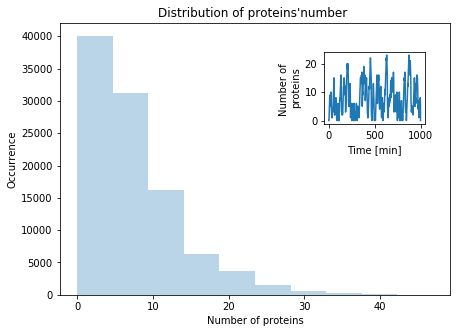

In [5]:
fig=plt.figure(figsize=(7,5))
ax=fig.add_subplot(111,title="Distribution of proteins'number ")
ax.hist(N,alpha=0.3)
ax.set(xlabel='Number of proteins',ylabel='Occurrence')
a=plt.axes([.65,.6,.2,.2])
a.plot(N[:1000])
a.set(xlabel='Time [min]',ylabel='Number of \nproteins')
#fig.savefig('prot.pdf')

[Text(0, 0.5, 'Number of \n mRNAs'), Text(0.5, 0, 'Time [min]')]

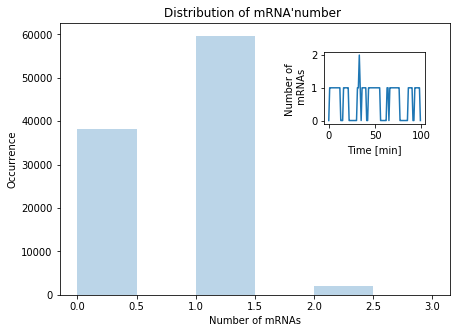

In [6]:
fig=plt.figure(figsize=(7,5))
ax=fig.add_subplot(111,title="Distribution of mRNA'number ")
ax.hist(M,alpha=0.3,bins=6)
ax.set(xlabel='Number of mRNAs',ylabel='Occurrence')
a=plt.axes([.65,.6,.2,.2])
a.plot(M[:100])
a.set(xlabel='Time [min]',ylabel='Number of \n mRNAs')

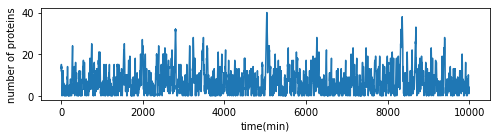

In [7]:
figure(figsize=(7,2))
plot(N[-10000:])
xlabel("time(min)")
ylabel("number of proteins")
tight_layout()
#savefig("traj.png", dpi=300)

In [8]:
print("temporal average M: %.3f   expected: %.3f"
      % (sum(M[:-1]*diff(T[:]))/T[-1], bm/am))
print("temporal average N: %.3f   expected: %.3f"
      % (sum(N[:-1]*diff(T[:]))/T[-1], bn*bm/an/am))

temporal average M: 0.037   expected: 0.037
temporal average N: 3.614   expected: 5.927


In [9]:
dt = 3
tx,nx = unique(dt*rint(Tp/dt), return_counts=True) #divisione in 3 minuti
txm,nxm = unique(dt*rint(Tm/dt),return_counts=True) 

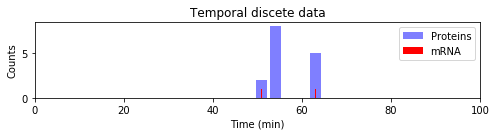

In [10]:
Tmax = 100
fig=figure(figsize=(7,2))
ax=fig.add_subplot(111,title='Temporal discete data')
ax.bar(tx[tx<Tmax], nx[tx<Tmax], width=2.5, alpha=.5,color='blue',label='Proteins')
ax.bar(txm[txm<Tmax], nxm[txm<Tmax], width=.2, color="red",label='mRNA')
ax.set_xlim(0,Tmax)
ax.set(xlabel="Time (min)",ylabel="Counts")
ax.legend()
tight_layout()
#savefig("simubursts.pdf")

## Numero di molecole per burst

In [11]:
def findburst(tx, nx):
    Tb = []
    Nb = []
    tb = tx[0]
    nb = nx[0]
    for i in range(1,len(tx)):
        if tx[i]-tx[i-1] == 3:
            nb += nx[i]
        else: 
            # a burst has finished...
            Tb += [tb]
            Nb += [nb]
            # and a new one is starting
            nb = nx[i]
            tb = tx[i]
    Tb += [tb]
    Nb += [nb]
    
    return array(Tb), array(Nb)

In [12]:
Tb, Nb = findburst(tx, nx)

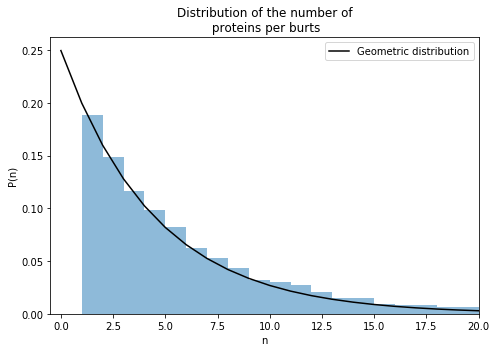

In [13]:
fig=plt.figure(figsize=(7,5))
ax=fig.add_subplot(111,title='Distribution of the number of\n proteins per burts')
ax.hist(Nb, range=[0,32], bins=32, density=True, alpha=.5);
nn = arange(30)
rho = bn/(bn+am)
ax.plot(nn, (1-rho)/rho*rho**nn, 'k',label='Geometric distribution')
xlabel("n")
ylabel("P(n)")
xlim(-.5, 20)
ax.legend()
tight_layout()
#savefig("prot_burst.pdf")

In [45]:
print(rho)
print(1/(1-rho),mean(Nb))

0.8001998001998002
5.005 5.651507955355022


## Numero di proteine per burst

In [14]:
def burst(tx):
    b=0
    Nbc=[]
    k=0
    t0=tx[0]
    for i in range(1,len(tx)):
        tc=(tx[i]-t0)//55 #numero di ciclo rispetto all'origine
        if k==tc:
            b+=1
        else:
            while(k!=tc):
                k+=1
                Nbc+=[b]
                b=0
            b=1
    return(array(Nbc))

#poissoniana
def pois(n,l=10):
    return(l**n/sp.gamma(n+1)*exp(-l))

In [15]:
Nbc=burst(Tb)
nb=amax(Nbc)
pbh,Nbh=np.histogram(Nbc,bins=nb,density=True)

In [16]:
op.curve_fit(pois,arange(0,nb),pbh,46/60)

(array([1.02500469]), array([[0.00235244]]))

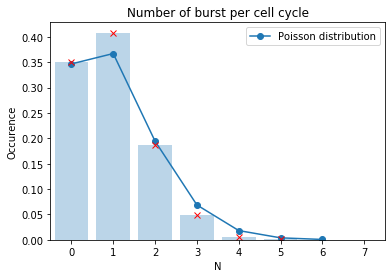

In [17]:
plt.close()
fig=plt.figure()
ax=fig.add_subplot()
ax.bar(arange(0,nb),pbh,alpha=0.3)
ax.plot(arange(0,nb+1),pois(arange(0,nb+1),1.0589774),marker='o',label='Poisson distribution')
ax.plot(arange(0,nb),pbh,'rx')
ax.set(xlabel='N',ylabel='Occurence',
       title='Number of burst per cell cycle')
ax.set_xlim(-0.5,nb+1.5)
ax.legend()
#fig.savefig('bursthist.pdf')

## Funzione di autocorrelazione
$$G(\tau)=\lim_{N\rightarrow\infty}\frac{1}{N}\sum_{i,j}\delta(t_j-t_i-\tau)$$
$$C^{(2)}(\tau)=\nu\  G(\tau)$$

In [18]:
print(len(tx),len(txm))

12738 11410


In [19]:
hist(ifft(fft(Ttm)**2),density=True)

NameError: name 'Ttm' is not defined

In [20]:
diff(txm)

array([ 12., 105.,  24., ...,  24.,  12.,  18.])

In [34]:
#Creazione vettore tempi produzioen mRNA
#Vedo se è poissoniana
df=pd.DataFrame(np.zeros(len(txm)))
for k in range(10):
    df[str(k)]=diff(txm,n=k)
df

ValueError: Length of values does not match length of index

In [31]:
df.plot.hist()

TypeError: no numeric data to plot

In [36]:
# creazione della funzione attraverso la definizione
#Nel loro grafico si arriva a 120=40*3
X=np.zeros(80//3)
X1=np.ones(len(tx))
for i in range(80//3):
    for j in range(0,len(tx)):
        X[i]+=np.sum(X1[(tx-tx[j]).astype(int)==i*3])
X=X/sum(X)

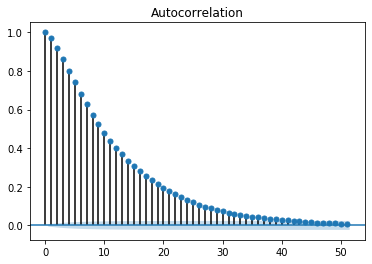

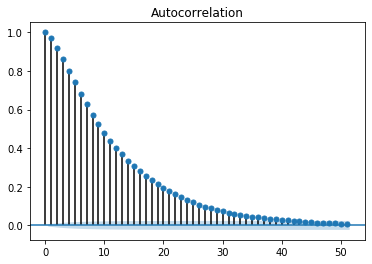

/Users/carlitos98/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


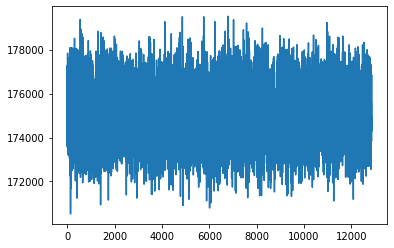

In [44]:
plt.plot(ifft(fft(nx)**2))

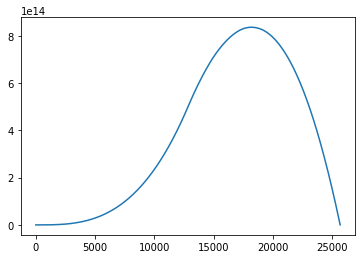

In [ ]:
Xm=np.zeros(80//3)
X1=np.ones(len(tx))
for i in range(80//3):

In [48]:
#funzione del documento
def c2(t,s=1/29,r=0.7,k=60/7):
    return((1+k/s*np.exp(-k*t))*(s*r/(1-r))**2)

In [39]:
Tc=arange(0,len(X)*3,3)

In [65]:
pa,pacov=op.curve_fit(c2,Tc,X,[1/29,1/1.8,0.8])
print(pa)
print(pacov)

[0.03669408 0.80726193 0.43868058]
[[ 1.07837686e-06 -3.46581267e-06  5.92008058e-06]
 [-3.46581267e-06  1.17326608e-05 -2.23818084e-05]
 [ 5.92008058e-06 -2.23818084e-05  5.99186899e-05]]


In [95]:
print(1/29,1/1.8,0.8)

0.034482758620689655 0.5555555555555556 0.8


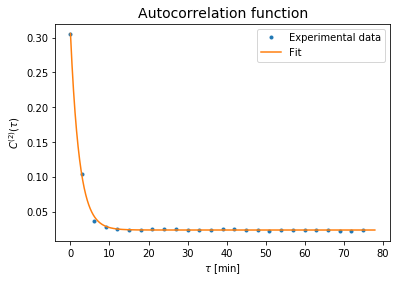

In [63]:
#0.03901055, 0.7988902 , 0.45379533
fig=plt.figure()
ax=fig.add_subplot()
ax.plot(Tc,X,'.',label='Experimental data')
ax.plot(linspace(0,len(X),1000)*3,
        c2(linspace(0,len(X),1000)*3,*pa),label='Fit')
ax.set(xlabel=r'$\tau$ [min]',
      ylabel=r'$C^{(2)}(\tau)$')
ax.set_title("Autocorrelation function",fontsize=14)
ax.legend()
#fig.savefig('autocorr.pdf')